In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(44)

In [3]:
import os
import math
import time
import itertools
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from data.othello import Othello, OthelloBoardState, permit_reverse
from mingpt.dataset import CharDataset
from mingpt.utils import sample
from mingpt.model import GPT, GPTConfig
from mingpt.trainer import Trainer, TrainerConfig

### Util functions

In [4]:
def load_othello_model(ckpt):
    # original OthelloGPT params: n_layer=8, n_head=8, n_embd=512
    # vocab_size = 59, block_size = 61 for othello
    mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)
    model = GPT(mconf)
    load_res = model.load_state_dict(torch.load(f"./ckpts/{ckpt}.ckpt"))
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        model = model.to(device)
        return model, device
    else:
        print("NO GPU FOUND")

In [5]:
def draw_board_heatmap(board, **kwargs):
    fig = plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    sns.heatmap(board.reshape(8, 8), **kwargs,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")
    return fig

In [6]:
def draw_heatmap_from_tokens(token_pred, **kwargs):
    # take off first token, as it isn't a board position
    token_pred = token_pred[1:]
    # add padding to get from tokens -> board positions
    padding = np.zeros(2)
    board = np.concatenate([token_pred[:27], padding, token_pred[27:33], padding, token_pred[33:]], axis=0)
    # plotting
    return draw_board_heatmap(board, **kwargs)
    

### Legal move validation

In [9]:
def quick_validate(model_ckpt, dataset, n_games=1000, quiet=False):
    # othello = Othello(data_root=dataset, n_games=n_games, test_split=0, deduplicate=False, quiet=quiet)
    # train_dataset = CharDataset(othello, quiet=quiet)
    # for playertype games
    othello = Othello(data_root="othello_1player", n_games=n_games, test_split=0, deduplicate=False, quiet=quiet)
    games = [p[1] for p in othello]
    train_dataset = CharDataset(games)

    loader = DataLoader(train_dataset, shuffle=False, pin_memory=True,
                                    batch_size=64,
                                    num_workers=0)

    model, device = load_othello_model(model_ckpt)

    total_nodes = 0
    success_nodes = 0
    def progress_report():
        return f"{success_nodes/total_nodes*100:.4f}% pass rate: {success_nodes}/{total_nodes} among all searched nodes"

    all_pred = np.zeros((0, 59))

    for it, (x, y) in enumerate(loader):
        x = x.to(device)
        logits, _ = model(x)
        pred = torch.argmax(logits, dim=2).detach().cpu().numpy()
        # pred is [batch size, block_size (59 for normal othello setup)]

        all_pred = np.concatenate((all_pred, pred), axis=0)

    bar = tqdm(games, disable=quiet)
    # bar = tqdm(othello, disable=quiet)
    for i_seq, seq in enumerate(bar):
        if -100 in seq:
            seq = seq[:seq.index(-100)]

        for len_partial in range(1, len(seq)):
            total_nodes += 1
            context = seq[:len_partial]
            completion = train_dataset.itos[int(all_pred[i_seq][len_partial-1])]
            context.append(completion)
            try:
                OthelloBoardState().update(context)
            except Exception:
                # print(completion)
                pass
            else:
                success_nodes += 1
        
        bar.set_description(progress_report())

    return success_nodes, total_nodes

In [11]:
sn, tn = quick_validate("playertype", "othello_1player", n_games=1000)
print(sn / tn)

Mem Used: 4.23 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 1000 for training, 0 for validation
Dataset created has 1000 sequences, 61 unique words.


99.7814% pass rate: 58423/58551 among all searched nodes: 100%|██████████| 1000/1000 [00:36<00:00, 27.51it/s]

0.9978138716674352


In [8]:
# models = ["control", "bias50", "bias80", "bias95"]
# datasets = ["synthetic", "TLbias50", "TLbias80", "TLbias95"]
# models = [f"ft_bias50_100__20230718_132649_e{i}" for i in [1, 10, 50, 100, 200]]
models = ["playertype"]
datasets = ["synthetic", "TLbias50", "TLbias80", "BRbias50", "BRbias80"]

for m in models:
    acc = []
    for d in datasets:
        print(m, d)
        sn, tn = quick_validate(m, f"othello_{d}", n_games=1000, quiet=True)
        acc.append(sn / tn)
    print(", ".join([str(x) for x in acc]))


playertype synthetic


playertype TLbias50
playertype TLbias80
playertype BRbias50
playertype BRbias80
0.9867662029182219, 0.993813521873619, 0.998118242780895, 0.9921088804792371, 0.9970796686875587


### Illegal probability mass

In [14]:
# calculating illegal probability share
othello = Othello(data_root="othello_synthetic", n_games=1000, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)
loader = DataLoader(train_dataset, shuffle=True, pin_memory=True,
                                batch_size=64,
                                num_workers=0)

model, device = load_othello_model("playertype_e20")

Mem Used: 4.404 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 1000 for training, 0 for validation
Dataset created has 1000 sequences, 61 unique words.


In [17]:
def calc_batched_pred(model_ckpt, dataset):
    othello = Othello(data_root=dataset, n_games=1000, test_split=0, deduplicate=False)
    train_dataset = CharDataset(othello)
    loader = DataLoader(train_dataset, shuffle=True, pin_memory=True,
                                    batch_size=64,
                                    num_workers=0)

    model, device = load_othello_model(model_ckpt)

    # device = torch.cuda.current_device()
    stoi = np.vectorize(train_dataset.stoi.get) # othello move to token
    itos = np.vectorize(train_dataset.itos.get) # token to othello move

    batched_pred = np.zeros((59, 61))

    for x, y in tqdm(loader):
        # saving board positions for updating game state
        moves = x.numpy()
        moves = itos(moves)

        x = x.to(device)  # [B, T]
        y = y.to(device)  # [B, T]
        logits, loss = model(x, y)
        
        logits = torch.softmax(logits, dim=2)
        pred = logits.detach().cpu().numpy()
        # pred is [batch size, block_size (59 for normal othello setup), vocab_size (61 for normal othello setup)]
        # print(pred.shape)

        legal_mask = np.zeros(pred.shape)
        for game in range(pred.shape[0]):
            ob = OthelloBoardState()
            # print(moves[game])
            for i, m in enumerate(moves[game]):
                if m == -100:
                    break
                ob.update([m])
                valid = ob.get_valid_moves()
                if valid:
                    legal_mask[game, i, stoi(valid)] = 1

        # legal_prob = pred * legal_mask
        illegal_prob = pred * (1 - legal_mask)

        np.add(batched_pred, illegal_prob.sum(axis=0), out=batched_pred)

    return batched_pred

In [18]:
batched = calc_batched_pred("playertype_e20", "othello_synthetic")

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 4.559 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 1000 for training, 0 for validation
Dataset created has 1000 sequences, 61 unique words.


100%|██████████| 16/16 [00:33<00:00,  2.07s/it]


In [ ]:
to_save = {}
for c in ["control", "bias50", "bias80", "bias95"]:
    for dr in ["synthetic", "TLbias50", "TLbias80", "TLbias95"]:
        print(f"======== ckpt: {c} | data: {dr} =========")
        arr = calc_batched_pred(f"bias/TL{c}", f"othello_{dr}")
        to_save[f"{c}_{dr}"] = arr

np.savez('illegal_move_mass.npz', **to_save)
        

In [18]:
raw = np.load("visuals/data/illegal_move_mass10k.npz")

data = {}
for k,v in raw.items():
    model, dataset = k.split("_")
    if model not in data:
        data[model] = {}
    data[model][dataset] = v.sum(axis=1)

print(data.keys())
print(data['control'].keys())

dict_keys(['control', 'bias50', 'bias80', 'bias95'])
dict_keys(['synthetic', 'TLbias50', 'TLbias80', 'TLbias95'])


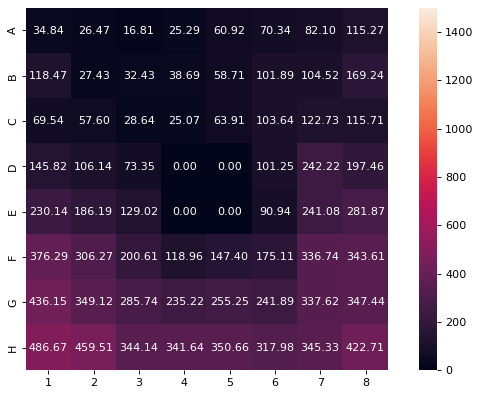

In [17]:
fig = draw_heatmap_from_tokens(data["bias50"]["TLbias50"], vmax=1500)

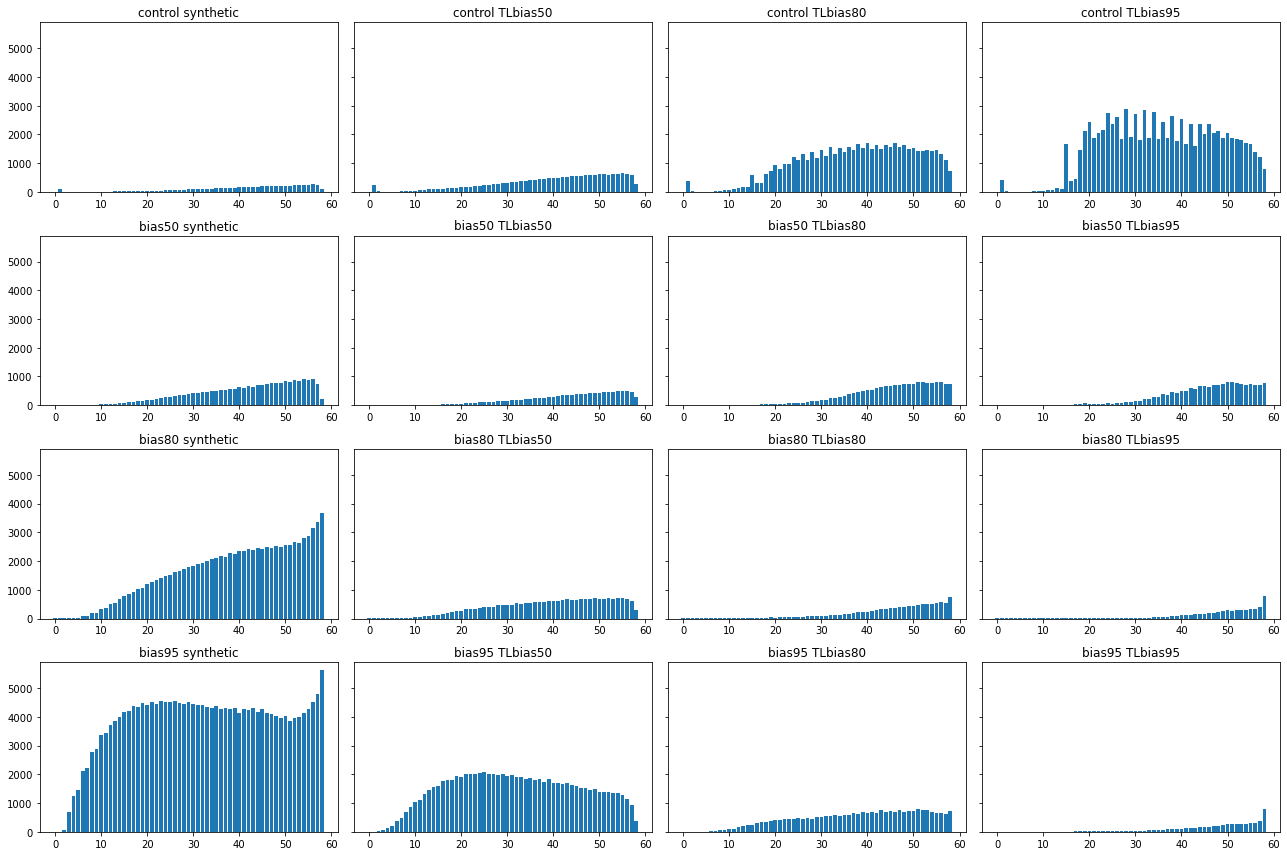

In [19]:
# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(18, 12), sharey=True)

# Iterate over each subplot
for i, model_name in enumerate(data):
    for j, dataset_name in enumerate(data[model_name]):
        y = data[model_name][dataset_name]
        # Plot the bar chart for each subplot
        axs[i, j].bar(range(len(y)), y)
        axs[i, j].set_title(f"{model_name} {dataset_name}")

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()

### Animating merged predictions

In [36]:
# calculating aggregated predictions

model, device = load_othello_model("playertype_e20")

# othello = Othello(data_root="othello_synthetic", n_games=1000, test_split=0, deduplicate=False)
# train_dataset = CharDataset(othello)

othello = Othello(data_root="othello_1player", n_games=5000, test_split=0, deduplicate=False)
games = [p[1] for p in othello if p[0] == 0]
train_dataset = CharDataset(games)

loader = DataLoader(train_dataset, shuffle=True, pin_memory=True,
                                batch_size=64,
                                num_workers=0)

merged_pred = np.zeros((59, 61))
device = torch.cuda.current_device()
for x, y in loader:
    x = x.to(device)  # [B, T]
    y = y.to(device)  # [B, T]
    logits, loss = model(x, y)
    
    logits = torch.softmax(logits, dim=2)
    pred = logits.detach().cpu().numpy()
    # print(pred.shape)
    batch_pred = np.sum(pred, axis=0)
    np.add(merged_pred, batch_pred, out=merged_pred)

print(merged_pred.shape)

Mem Used: 4.577 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 5000 for training, 0 for validation
Dataset created has 1275 sequences, 61 unique words.
(59, 61)


In [ ]:
# generates an animated gif of heatmaps over the course of the game

from PIL import Image

heatmap_images = []

for move in range(merged_pred.shape[0]):
    # move_prob = merged_pred[move][1:]
    # padding = np.zeros(2)
    # board = np.concatenate([move_prob[:27], padding, move_prob[27:33], padding, move_prob[33:]], axis=0)
    
    # fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    # sns.heatmap(board.reshape(8, 8), vmin=0, vmax=200,
    #             yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True,
    #             annot=True, fmt=".2f")
    fig = draw_heatmap_from_tokens(merged_pred[move], vmin=0, vmax=200)

    # Convert the heatmap plot to an image
    fig.canvas.draw()
    heatmap_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    heatmap_images.append(heatmap_image)

heatmap_images[0].save('heatmap_animation.gif', save_all=True, append_images=heatmap_images[1:], loop=0)

### Visualizing individual board states

In [39]:
model, device = load_othello_model("bias/TLcontrol")

In [5]:
ex_games = Othello(data_root="othello_synthetic", n_games=5, test_split=1)
train_dataset = CharDataset(ex_games.val)

Mem Used: 1.114 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Deduplicating finished with 5 games left
Using 0 for training, 5 for validation
Dataset created has 5 sequences, 61 unique words.


In [6]:
partial_game = ex_games.val[0][:7]
# partial_game = [19, 18, 17, 20, 21, 12, 37, 30, 14, 43, 26, 34, 39, 38, 46, 9, 42, 33, 4, 55, 32, 13, 44, 41, 0, 25, 3]
# partial_game = [19, 18, 17, 20, 21, 12, 37, 30, 14, 43, 26, 34, 39, 38, 46, 9, 42, 33, 4, 55, 32, 13, 44, 41, 0, 25]
# partial_game = [19, 18, 17, 9, 1, 0, 26, 2, 10, 11, 3, 4, 8, 16, 37, 12, 5, 6, 13]
ob = OthelloBoardState()
ob.update(partial_game)
ob.__print__()
print([permit_reverse(x) for x in ob.get_valid_moves()])

--------------------
['e6', 'd6', 'c7', 'f5', 'c6', 'b8', 'd7']
a                
b               O
c           X O  
d       O X X X  
e       X O X    
f         O      
g                
h                
  1 2 3 4 5 6 7 8
--------------------
['c5', 'c8', 'd3', 'd8', 'e3', 'e7', 'f4']


In [19]:
# load partial game onto GPU
history = torch.tensor([train_dataset.stoi[s] for s in partial_game], dtype=torch.long).to(device)
# get model prediction
pred, _ = model(history[None, :]) 
# transform into probability for each board state
pred = pred[0, -1, 1:]
padding = torch.zeros(2).cuda()
pred = torch.softmax(pred, dim=0)
pred = torch.cat([pred[:27], padding, pred[27:33], padding, pred[33:]], dim=0)

<AxesSubplot:>

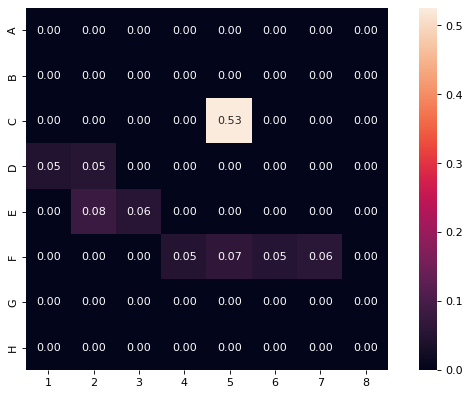

In [20]:
# plotting
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(pred.detach().cpu().numpy().reshape(8, 8), 
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")

### correlations in othello board

In [102]:
from scipy.stats.contingency import association, crosstab

othello = Othello(n_games=10000, test_split=0, deduplicate=False, quiet=True)

In [103]:
# [num_games, length of game, board size]
board_states = np.zeros((len(othello), 60, 64), dtype=int) - 1

for i, seq in enumerate(othello):
    # print("seq", i)
    ob = OthelloBoardState()
    for j, move in enumerate(seq):
        state = ob.get_state()
        board_states[i, j] = state

        ob.update([move])

print(board_states.shape)

(10000, 60, 64)


In [7]:
board_states = np.load("visuals/data/board_states_10k.npy")
print(board_states.shape)

(10000, 60, 64)


In [108]:
# white 0, blank 1, black 2
counts = np.zeros((64, 3, 3), dtype=int)

options = [0, 1, 2]
pos1 = board_states[:, :, 26].flatten()
for i in range(64):
    pos2 = board_states[:, :, i].flatten()
    res = crosstab(pos1, pos2, levels=(options, options))
    counts[i] = res.count

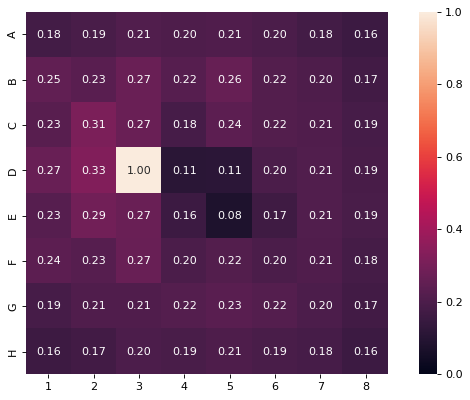

In [110]:
# chi2, p, dof, expected = chi2_contingency(counts)
# cv = association(counts, method='cramer')

V = np.zeros(64)
for i in range(len(V)):
    col_mask = np.sum(counts[i], axis=0) != 0
    row_mask = np.sum(counts[i], axis=1) != 0
    adj_counts = counts[i][row_mask, :]
    adj_counts = adj_counts[:, col_mask]
    V[i] = association(adj_counts, method='cramer')

fig = draw_board_heatmap(V, vmin=0, vmax=1)

In [34]:
probe_baseline = np.zeros((60, 64))
most_common = np.zeros((60, 64))

for time_step in range(60):
    for i in range(64):
        unique, counts = np.unique(board_states[:, time_step, i].flatten(), return_counts=True)
        # don't want to consider -1 in baseline
        probe_baseline[time_step, i] = np.max(counts) / np.sum(counts)
        most_common[time_step, i] = unique[np.argmax(counts)]

print(probe_baseline[5])
print(most_common[5])

[1.     0.9994 1.     0.9962 0.9996 0.999  1.     1.     0.9994 0.9733
 0.945  0.9566 0.959  0.9352 0.9976 1.     1.     0.9455 0.6343 0.5658
 0.6685 0.8394 0.9361 0.9985 0.9961 0.9574 0.5752 0.612  0.785  0.6732
 0.9565 0.9991 0.9995 0.9523 0.6628 0.7801 0.6175 0.5699 0.9584 0.9962
 0.9983 0.9314 0.844  0.6589 0.5683 0.6367 0.9484 1.     1.     0.9979
 0.9339 0.9614 0.9584 0.9491 0.9739 0.9997 1.     1.     0.9986 0.9997
 0.9969 1.     0.9995 1.    ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
